In [1]:
!nvidia-smi

Mon Sep 28 15:48:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install pymystem3

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


# DATA

In [6]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
test = pd.read_csv(DATA_DIR + 'test.csv')
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.concat([test,train], axis=0)
autoru = pd.read_csv(os.path.join('..','input', 'autoru', 'autoru_cleared.csv'))
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [7]:
column_rename_dict ={'bodyType': 'body_type',
                    'brand': 'manufacturer_name',
                    'mileage': 'odometer_value',
                    'vehicleTransmission': 'transmission',
                    'productionDate': 'year_produced',
                    'fuelType': 'engine_fuel',
                    'engineDisplacement': 'engine_capacity',
                    'enginePower': 'engine_power',
                    'Привод': 'drivetrain',
                    'model_info': 'model_name',
                     
}

autoru = autoru.rename(columns={'Name': 'name'})
autoru.drop(columns=['Engine'], inplace=True)

test = test.rename(columns=column_rename_dict)

set(autoru.columns).symmetric_difference(test.columns)

{'description',
 'modelDate',
 'model_name',
 'numberOfDoors',
 'sell_id',
 'vehicleConfiguration',
 'Владельцы',
 'Владение',
 'ПТС',
 'Руль'}

In [8]:
def clear_eng_power(hp):
    value = str(hp).split()[0]
    if value == 'undefined':
        return 2.0  # median value for capacity
    return float(value)


test['year_produced'] = test['year_produced'].astype('int32')
test['odometer_value'] = test['odometer_value'].astype('int32')


test['engine_power'] = test['engine_power'].apply(clear_eng_power)
test['engine_capacity'] = test['engine_capacity'].apply(clear_eng_power)





autoru = autoru[autoru['manufacturer_name'].isin(test['manufacturer_name'])]

autoru['power_per_volume'] = autoru['engine_power']/autoru['engine_capacity']
test['power_per_volume'] = test['engine_power']/test['engine_capacity']

autoru = autoru[autoru['engine_capacity'] < 7]
autoru = autoru[autoru['odometer_value'] > 0]

In [9]:
def calculate_tax(power):
    tax_dict ={
        '100': 2.5,
        '150': 3.5,
        '200': 5,
        '250': 7.5,
        'max': 15
    }
    key = ''

    if power <= 100:
        key = '100'
    elif power <= 150:
        key = '150'
    elif power <= 200:
        key = '200'
    elif power <= 250:
        key = '250'
    else:
        key = 'max'

    return power*tax_dict[key]
                    
#roughly estimate expected yearly tax        
autoru['tax'] = autoru['engine_power'].apply(calculate_tax)
test['tax'] = test['engine_power'].apply(calculate_tax)

In [10]:
#bring numerical data to a conviniet format

autoru['engine_capacity'] = (autoru['engine_capacity']*10).astype('int32')
test['engine_capacity'] = (test['engine_capacity']*10).astype('int32')

autoru['odometer_value'] = (autoru['odometer_value']//10000).astype('int32')
test['odometer_value'] = (test['odometer_value']//10000).astype('int32')

autoru['engine_power'] = (autoru['engine_power']).astype('int32')
test['engine_power'] = (test['engine_power']).astype('int32')

# CatBoost

### Feature selection and preparation for model training

In [11]:
cat_features = ['body_type',#0
                'transmission',#1
                'engine_fuel',#2
                'color',#3
                'drivetrain',#4
                'year_produced',#5
]

num_features = ['engine_capacity', #6
                'engine_power',#7
                'odometer_value',#8
                'power_per_volume',#9
                'tax'#10
]

#feature selection
autoru = autoru[cat_features+num_features+['price']]
test_distilled = test[cat_features+num_features+['price']]
test_catboost = test_distilled[~test_distilled['price'].isna()]
test_catboost_pred = test_distilled[test_distilled['price'].isna()]

In [12]:
#make features categorical to speed up catboost a little
for feature in cat_features:
    autoru[feature] = autoru[feature].astype('category')
    test_catboost[feature] = test_catboost[feature].astype('category')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
X_train = autoru.drop(['price'], axis=1)
y_train = ((autoru['price'])**0.5) #sqrt of target variable for better distribution. It helps.
X_test = test_catboost.drop(['price'], axis=1)
y_test = (test_catboost['price']**0.5)

In [14]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

### Training and prediction

In [15]:
ITERATIONS   = 1500
LR           = 0.04
CAT_FEATURES = [0,1,2,3,4,5,6,7]

from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          eval_metric = 'MAPE',
                          custom_metric = ['R2', 'MAE'],
                          early_stopping_rounds = 100
                         )

model.fit(X, y,
            cat_features=CAT_FEATURES,
            eval_set=(X_test, y_test),
            verbose_eval=500,
            use_best_model=True,
            plot=True
            )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4308037	test: 0.2963947	best: 0.2963947 (0)	total: 225ms	remaining: 5m 37s
500:	learn: 0.0769325	test: 0.0697192	best: 0.0697192 (500)	total: 1m 17s	remaining: 2m 34s
1000:	learn: 0.0715806	test: 0.0653516	best: 0.0653516 (1000)	total: 2m 41s	remaining: 1m 20s
1499:	learn: 0.0689039	test: 0.0631205	best: 0.0631205 (1499)	total: 4m 7s	remaining: 0us

bestTest = 0.06312050059
bestIteration = 1499



In [16]:
from sklearn.metrics import mean_absolute_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


print(mape(y_test**2, model.predict(X_test)**2))
print(mean_absolute_error(y_test**2, model.predict(X_test)**2))

pred = model.predict(test_catboost_pred.drop(['price'], axis=1))
cat_submission = pd.DataFrame()
cat_submission['sell_id'] = test[test['price'].isna()]['sell_id'].values
cat_submission['price'] = pred
cat_submission['price'] = (cat_submission['price']**2) #REVERT SQRT
cat_submission.to_csv(f'submission_catboost.csv', index=False)

0.12744191989355924
250231.53168885745


In [17]:
test['catboost_predict'] = model.predict(test_distilled.drop(['price'], axis=1)) #write SQRT catboost predictions

# Preprocessing for NN

In [18]:
test = test.rename(columns={
            'Владельцы': 'owners',
            'ПТС': 'pts',
            'Руль': 'steering',
            'Владение': 'owned_for',
})

In [19]:
def extract_ownage_in_month(text):
    if type(text)== float:
        return text
    splited = text.split()
    if len(splited)==2:
        return int(splited[0])
    elif len(splited)==5:
        return int(splited[0]) + int(splited[3])
        
    
test['owned_for'] = test['owned_for'].apply(extract_ownage_in_month)
test['owned_for'] = test['owned_for'].fillna(test['owned_for'].median())

test['odometer_value'] = test['odometer_value']**0.5

In [20]:
test['owners'] = test['owners'].fillna('2').apply(lambda x: x.split()[0]).astype('int32')

In [21]:
test.T.head(25)[0]

0  \
body_type                                               универсал 5 дв.   
manufacturer_name                                              MERCEDES   
color                                                            чёрный   
description           Всем привет!\n\nПродам эксклюзивный проект 124...   
engine_capacity                                                      30   
engine_power                                                        220   
engine_fuel                                                      бензин   
odometer_value                                                  5.91608   
modelDate                                                          1984   
model_name                                                         W124   
name                                              300 3.0 AT (220 л.с.)   
numberOfDoors                                                         5   
year_produced                                                      1991   
sell_id                                                      1099427284   
vehicleConfiguration                        WAGON_5_DOORS AUTOMATIC 3.0   
transmission                                             автоматическая   
owners                                                                3   
owned_for                                                             9   
pts                                                            Оригинал   
drivetrain                                                       задний   
steering                                                          Левый   
price                                                               NaN   
power_per_volume                                                73.3333   
tax                                                                1650   
catboost_predict                                                696.407   

                                                                      0  
body_type                                                         седан  
manufacturer_name                                                   BMW  
color                                                            чёрный  
description           Авто на бодром ходу.  Все работает отлично.  П...  
engine_capacity                                                      30  
engine_power                                                        272  
engine_fuel                                                      бензин  
odometer_value                                                  4.89898  
modelDate                                                          2007  
model_name                                                          5ER  
name                                        530xi 3.0 AT (272 л.с.) 4WD  
numberOfDoors                                                         4  
year_produced                                                      2007  
sell_id                                                      1099980990  
vehicleConfiguration                                SEDAN AUTOMATIC 3.0  
transmission                                             автоматическая  
owners                                                                3  
owned_for                                                             9  
pts                                                            Оригинал  
drivetrain                                                       полный  
steering                                                          Левый  
price                                                            599000  
power_per_volume                                                90.6667  
tax                                                                4080  
catboost_predict                                                796.634

In [22]:
categorial_columns = ['body_type',
                      'manufacturer_name',
                      'color',
                      'engine_fuel',
                      'modelDate',
                      'model_name',
                      'year_produced',
                      'numberOfDoors',
                      'transmission',
                      'pts',
                      'drivetrain',
                      'steering',
                     ]
numerical_columns = ['engine_capacity',
                     'engine_power',
                     'odometer_value',
                     'owned_for',
                     'power_per_volume',
                     'tax',
                     'owners',
                     
]


for column in categorial_columns:
    test[column] = test[column].astype('category')

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(test[numerical_columns][~test['price'].isna()])
scaled_numerical = pd.DataFrame(scaler.transform(test[numerical_columns]), columns=numerical_columns)
dummies = pd.get_dummies(test[categorial_columns])

In [24]:
dummies.reset_index(drop=True, inplace=True)

test_for_nn = pd.concat([scaled_numerical, dummies], axis=1)

X = test_for_nn[~test.reset_index(drop=True)['price'].isna()].to_numpy()
y = test[~test['price'].isna()].reset_index(drop=True)['price'].to_numpy()

X_unknown = test_for_nn[test.reset_index(drop=True)['price'].isna()].to_numpy()

In [25]:
X.shape, y.shape
#our training tabular data is now X and y

((6682, 266), (6682,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False, random_state=RANDOM_SEED)

# DL 1: Tabular NN

In [27]:
mlp = Sequential()
mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
mlp.add(L.Dropout(0.5))
mlp.add(L.Dense(256, activation='relu'))
mlp.add(L.Dropout(0.5))
mlp.add(L.Dense(256, activation='relu'))
mlp.add(L.Dropout(0.5))
mlp.add(L.Dense(64, activation='relu'))

tabular_model = Sequential()
tabular_model.add(mlp)
tabular_model.add(L.Dense(1, activation="linear"))

In [28]:
checkpoint = ModelCheckpoint('../working/best_tabular_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [29]:
LR = 0.0002

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
tabular_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAE'])


history = tabular_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=600,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

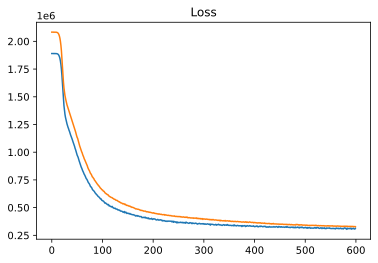

In [30]:
plt.title('Loss')
plt.plot(history.history['MAE'], label='train')
plt.plot(history.history['val_MAE'], label='test')
plt.show();

In [31]:
test_predict_nn1 = tabular_model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.19%


In [32]:
sub_predict_nn1 = tabular_model.predict(X_unknown)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('tabular_submission.csv', index=False)

# DL 2: NLP

In [33]:
# THX Alex Mamaev
# https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
russian_stopwords.remove('не')

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation+'«»“•' \
              and '\n' not in token]
    
    text = " ".join(tokens)
    
    return text

test['description'] = test['description'].apply(preprocess_text)

print(preprocess_text('Кошки не сидят на яблонях, они кушают кокосы!\nОчень уж они их любят)'))

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


кошка не сидеть яблоня кушать кокос очень любить


In [34]:
print(test['description'].sample().to_numpy())

['авто рука весь обслуживание регламент свеча масло фильтр жидкость ),  оригинальный запчасть весь сервисный история бк полностью обслуживать дилер следующий 10ткм работать идеально доустанавливать заводской навигация nbt пробка рукописный ввод текст улучшать щиток прибор улучшать акустика закодировать удобный функция эксплуатация новый летний зимний резина оба run flat торг капот 1 дтп припарковывать двор авто касательный передний бампер проехать таксист полностью требоваться программа bmw обеспечение безопасность поменяться дилер каско дтп ездить 2 год не переживать продавать причина необходимость больший авто']


In [35]:
test['description'].apply(len).quantile(0.75)

918.0

In [36]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 1000

### Tokenizer

In [37]:
%%time
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(test['description'])

CPU times: user 1.35 s, sys: 8.33 ms, total: 1.36 s
Wall time: 1.36 s


In [38]:
text_X = test[~test['price'].isna()]['description']
text_sub = test[test['price'].isna()]['description']

text_train, text_test = train_test_split(text_X, test_size=0.05, shuffle=False, random_state=RANDOM_SEED)

In [39]:
%%time
text_train_sequences = sequence.pad_sequences(tokenizer.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenizer.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenizer.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(6347, 1000) (335, 1000) (1671, 1000)
CPU times: user 1.43 s, sys: 6.2 ms, total: 1.43 s
Wall time: 1.43 s


In [40]:
print(text_train.iloc[56])
print(text_train_sequences[56])

данный автомобиль представлять автосалон мега моторс приобретать автомобиль получать гарантия высокий надежность сделка покупка гарантия приобретать автомобиль гарантия юридический чистота 100 % -  каждый автомобиль предварительно проверяться прием наш служба безопасность весь база гаи кредит залог автокод данный гарантия предоставляться письменный вид автомобиль отличный состояние автомобиль проводить полный предпродажный подготовка вложение не требовать лакокрасочный покрытие повреждение коробка двигатель работать нарекание предоставляться 1 год гарантия салон чистый не прокуривать птс оригинал второй комплект ключ сервисный книжка наличие покупка автомобиль кредит скидка 120 000 рубль данный автомобиль приобретать кредит ведущий банк страна минимальный комплект документ подача заявка кредит паспорт рф водительский удостоверение рассмотрение анкета короткий срок , ( течение час автокредит весь регион рф первоначальный взнос 0 процентный ставка кредит 9 годовой срок кредит  –  6 мес 7

### LTSM Model

In [41]:
lstm_nlp = Sequential(name='LSTM')
lstm_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
lstm_nlp.add(L.Embedding(len(tokenizer.word_index)+1, MAX_SEQUENCE_LENGTH,))
lstm_nlp.add(L.LSTM(350, return_sequences=True))
lstm_nlp.add(L.Dropout(0.5))
lstm_nlp.add(L.LSTM(256,))
lstm_nlp.add(L.Dropout(0.25))
lstm_nlp.add(L.Dense(256, activation="relu"))
lstm_nlp.add(L.Dropout(0.25))

nlp_model = Sequential()
nlp_model.add(lstm_nlp)
nlp_model.add(L.Dense(64, activation='relu'))
nlp_model.add(L.Dense(1, activation='linear'))

In [42]:
checkpoint = ModelCheckpoint('../working/best_nlp_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
callbacks_list = [checkpoint]

In [43]:
# training LSTM model solely on text description so it has to extract important features\
# without any information given to model head from tabular data

LR = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
nlp_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAE'])


history = nlp_model.fit(text_train_sequences, y_train,
                        batch_size=128,
                        epochs=12,
                        validation_data=(text_test_sequences, y_test),
                        callbacks=callbacks_list
                       )

Epoch 1/12
50/50 [==============================] - 48s 967ms/step - loss: 99.9958 - MAE: 1890139.7500 - val_loss: 99.9746 - val_MAE: 2083030.0000
Epoch 2/12
50/50 [==============================] - 48s 956ms/step - loss: 99.8268 - MAE: 1888316.3750 - val_loss: 99.5731 - val_MAE: 2078383.0000
Epoch 3/12
50/50 [==============================] - 48s 951ms/step - loss: 98.8954 - MAE: 1878296.7500 - val_loss: 98.0777 - val_MAE: 2061074.1250
Epoch 4/12
50/50 [==============================] - 48s 967ms/step - loss: 96.3525 - MAE: 1851069.3750 - val_loss: 94.6634 - val_MAE: 2021556.0000
Epoch 5/12
50/50 [==============================] - 47s 941ms/step - loss: 91.3304 - MAE: 1796946.7500 - val_loss: 88.5084 - val_MAE: 1950315.3750
Epoch 6/12
50/50 [==============================] - 48s 958ms/step - loss: 82.8614 - MAE: 1705914.1250 - val_loss: 78.6681 - val_MAE: 1836418.5000
Epoch 7/12
50/50 [==============================] - 48s 958ms/step - loss: 70.2248 - MAE: 1568939.6250 - val_loss: 65.

# DL 3: EFN image regressor

### Data

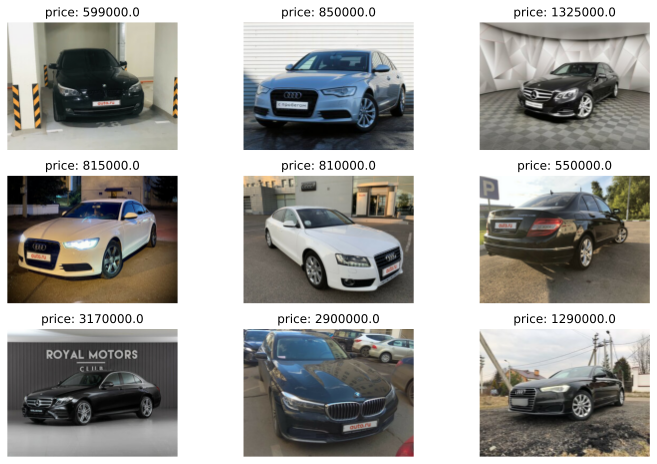

In [44]:
plt.figure(figsize = (12,8))

image = train.head(9)
image_paths = image['sell_id'].values
image_price = image['price'].values

for index, path in enumerate(image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(image_price[index]))
    plt.axis('off')
plt.show()

In [45]:
images_id_train, images_id_test = train_test_split(test[~test['price'].isna()]['sell_id'],
                                                    test_size=0.05,
                                                    shuffle=False,
                                                    random_state=RANDOM_SEED)

images_id_sub = test[test['price'].isna()]['sell_id']

In [46]:
size = (320, 240)

def get_image_array(series):
    images_train = []
    for sell_id in series.values:
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(images_id_train)
images_test = get_image_array(images_id_test)
images_sub = get_image_array(images_id_sub)

images shape (6347, 240, 320, 3) dtype uint8
images shape (335, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

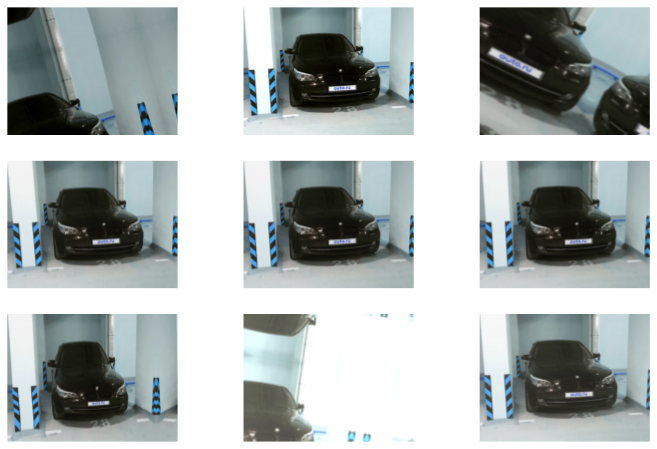

In [47]:
import albumentations

ALBUMENTATIONS = albumentations.Compose([
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.1),
    albumentations.RGBShift(p=0.1),
    albumentations.IAAPerspective(p=0.1),
    albumentations.GridDistortion(p=0.5),    
    albumentations.ShiftScaleRotate(p=0.2,
                                    shift_limit=0.5,
                                    scale_limit=0.5,
                                    rotate_limit=40,
    ),
    albumentations.ElasticTransform(p=0.4,
                                    alpha=0.1,
                                    sigma=5,
                                    alpha_affine=2,
    ),
])

plt.figure(figsize = (12,8))
for i in range(9):
    img = ALBUMENTATIONS(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [48]:
def process_image(image):
    return ALBUMENTATIONS(image = image.numpy())['image']

def tf_process_train_dataset_element(image, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return image, price

train_dataset = tf.data.Dataset.from_tensor_slices((images_train, y_train)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((images_test, y_test))

y_sub = np.zeros(len(X_unknown))

sub_dataset = tf.data.Dataset.from_tensor_slices((images_sub, y_sub))

### Model

In [49]:
efn_model = tf.keras.applications.EfficientNetB2(
                                                include_top=False,
                                                weights="imagenet",
                                                input_shape=(size[1], size[0], 3),
                                                pooling='avg',
                                                )

img_model = Sequential()
img_model.add(efn_model)

img_model.add(L.Dense(1024))
img_model.add(L.LeakyReLU(alpha=0.05))
img_model.add(L.Dropout(0.5))

img_model.add(L.Dense(256))
img_model.add(L.LeakyReLU(alpha=0.05))
img_model.add(L.Dropout(0.25))

img_model.add(L.Dense(64))
img_model.add(L.LeakyReLU(alpha=0.05))

img_model.add(L.Dense(1, activation=None))

31793152/31790344 [==============================] - 0s 0us/step


In [50]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor = 'val_loss', 
                            factor = 0.5, 
                            patience = 2, 
                            min_lr=0.00000001,
                            verbose=1,
                            mode='min')

checkpoint = ModelCheckpoint('../working/best_img_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')

earlystop = EarlyStopping(monitor='val_MAE', patience=4, restore_best_weights=True,)

callback_list = [reduce_lr, checkpoint, earlystop]

In [51]:
def unfreeze_model(model, layers):
    if layers>len(model.layers):
        raise ValueError
    for layer in model.layers[-layers:]:
        if not isinstance(layer, L.BatchNormalization):
            layer.trainable = True

print(f'Base model lenght = {len(efn_model.layers)}')

Base model lenght = 340


In [52]:
TRAINABLE_DEPTH_LIST = [30,   80,   120,  200,  290,  340]
LR = 1e-4
EPOCHS_PER_STEP = 3


for depth in TRAINABLE_DEPTH_LIST:

    print(f'Training {depth} layers')

    efn_model.trainable = False
    unfreeze_model(efn_model, depth)

    img_model.compile(
            loss='MAPE',
            optimizer=tf.optimizers.Adam(learning_rate=LR) ,
            metrics=['MAE']
    )
    img_model.fit(
            train_dataset.batch(32),
            validation_data = test_dataset.batch(32), 
            epochs = EPOCHS_PER_STEP,
            callbacks = callback_list
    )
    print()

Training 30 layers
Epoch 1/3
199/199 [==============================] - 50s 249ms/step - loss: 99.9647 - MAE: 1889818.5000 - val_loss: 99.8100 - val_MAE: 2081164.2500
Epoch 2/3
199/199 [==============================] - 46s 230ms/step - loss: 98.2770 - MAE: 1872041.3750 - val_loss: 95.7634 - val_MAE: 2035160.1250
Epoch 3/3
199/199 [==============================] - 47s 237ms/step - loss: 87.8184 - MAE: 1760874.3750 - val_loss: 79.0756 - val_MAE: 1845442.2500

Training 80 layers
Epoch 1/3
199/199 [==============================] - 49s 245ms/step - loss: 69.7179 - MAE: 1563900.8750 - val_loss: 64.6451 - val_MAE: 1676660.1250
Epoch 2/3
199/199 [==============================] - 47s 238ms/step - loss: 57.2506 - MAE: 1394891.0000 - val_loss: 54.3779 - val_MAE: 1520923.5000
Epoch 3/3
199/199 [==============================] - 48s 243ms/step - loss: 52.3338 - MAE: 1284706.3750 - val_loss: 51.3778 - val_MAE: 1443389.2500

Training 120 layers
Epoch 1/3
199/199 [==============================] -

# DL 4: Combine multiple inputs

In [53]:
test_cat_predict = test[~test['price'].isna()]['catboost_predict']
sub_cat_predict = test[test['price'].isna()]['catboost_predict']

train_cat_predict, val_cat_predict = train_test_split(test_cat_predict, test_size=0.05, shuffle=False, random_state=RANDOM_SEED)

In [54]:
def process_image(image):
    return ALBUMENTATIONS(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenizer.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, cb, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text, cb), price

def tf_process_val_dataset_element(image, table_data, text, cb, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text, cb), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train, train_cat_predict, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, text_test,val_cat_predict, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_unknown))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_unknown, text_sub, sub_cat_predict, y_sub
    )).map(tf_process_val_dataset_element)

try:
    train_dataset.__iter__().__next__();
    test_dataset.__iter__().__next__();
    sub_dataset.__iter__().__next__();
    print('Ok')
except:
    print('Dataset iteration error')

Ok


In [55]:
lstm_nlp.pop() # remove dropout from lstm model

unfreeze_model(efn_model, len(efn_model.layers)) # fully unfreeze efn model if frozen

In [56]:
cat_input = L.Input(shape=(1,), name='catboost')
cat_feature = L.Dropout(0.975)(cat_input) # to prevent overfitting on this feature
cat_feature = L.Dense(1, activation='relu')(cat_feature)
cat_model = Model(inputs=cat_input, outputs=cat_feature)

In [57]:
combinedInput = L.concatenate([efn_model.output, mlp.output, lstm_nlp.output, cat_model.output])

head = L.Dense(2056, activation="relu")(combinedInput)
head = L.Dropout(0.25)(head)
head = L.Dense(512, activation="relu")(head)
head = L.Dropout(0.25)(head)
head = L.Dense(256, activation="relu")(head)
head = L.Dropout(0.25)(head)
head = L.Dense(64, activation="relu")(head)
head = L.Dense(1, activation='linear')(head)

combined_model = Model(inputs=[efn_model.input, mlp.input, lstm_nlp.input, cat_model.input], outputs=head)

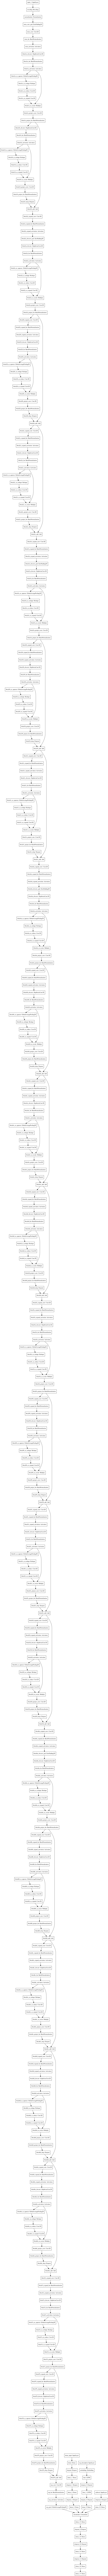

In [58]:
tf.keras.utils.plot_model(combined_model)

In [59]:
checkpoint = ModelCheckpoint('../working/best_combined_model.hdf5',
                             monitor=['val_loss'],
                             verbose=1,
                             mode='min')

earlystop = EarlyStopping(monitor='val_MAPE',
                          patience=4,
                          restore_best_weights=True,)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor = 'val_loss', 
                            factor = 0.5, 
                            patience = 2, 
                            min_lr=0.00000001,
                            verbose=1,
                            mode='min')

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [60]:
LR = 0.00001

optimizer = tf.keras.optimizers.Adam(LR)
combined_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAE'])

history = combined_model.fit(train_dataset.batch(15),
                            epochs=12,
                            validation_data=test_dataset.batch(15),
                            callbacks=callbacks_list
                           )

Epoch 1/12
424/424 [==============================] - ETA: 0s - loss: 45.4518 - MAE: 906586.3750
Epoch 00001: saving model to ../working/best_combined_model.hdf5
424/424 [==============================] - 284s 669ms/step - loss: 45.4518 - MAE: 906586.3750 - val_loss: 12.5340 - val_MAE: 352276.0938
Epoch 2/12
424/424 [==============================] - ETA: 0s - loss: 15.8361 - MAE: 352062.8750
Epoch 00002: saving model to ../working/best_combined_model.hdf5
424/424 [==============================] - 277s 654ms/step - loss: 15.8361 - MAE: 352062.8750 - val_loss: 12.3092 - val_MAE: 335760.5000
Epoch 3/12
424/424 [==============================] - ETA: 0s - loss: 15.4990 - MAE: 351370.5625
Epoch 00003: saving model to ../working/best_combined_model.hdf5
424/424 [==============================] - 280s 660ms/step - loss: 15.4990 - MAE: 351370.5625 - val_loss: 12.6951 - val_MAE: 356114.0625
Epoch 4/12
424/424 [==============================] - ETA: 0s - loss: 15.4064 - MAE: 348494.9375
Epoch 

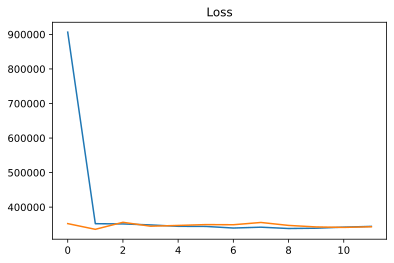

In [61]:
plt.title('Loss')
plt.plot(history.history['MAE'], label='train')
plt.plot(history.history['val_MAE'], label='test')
plt.show();

In [62]:
combined_model.load_weights('../working/best_combined_model.hdf5')
combined_model.save('../working/combined_final.hdf5')

In [63]:
test_predict_nn3 = combined_model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.38%


In [64]:
sub_predict_nn3 = combined_model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('final_submission.csv', index=False)